In [1]:
from psycopg2 import connect
import configparser
%matplotlib inline
import numpy as np
import pandas as pd
import pandas.io.sql as pandasql
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.ticker as ticker

CONFIG = configparser.ConfigParser()
CONFIG.read('db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

from IPython.display import HTML

def print_table(sql, con):
    return HTML(pandasql.read_sql(sql, con).to_html(index=False))

import datetime

# ATR Short-Term

## Visualizing the dataset

In [2]:
sql_volumes = '''
SELECT volume_15min
FROM open_data.volumes_atr_shortterm
'''
volumes = pandasql.read_sql(sql_volumes, con)

(0, 150000)

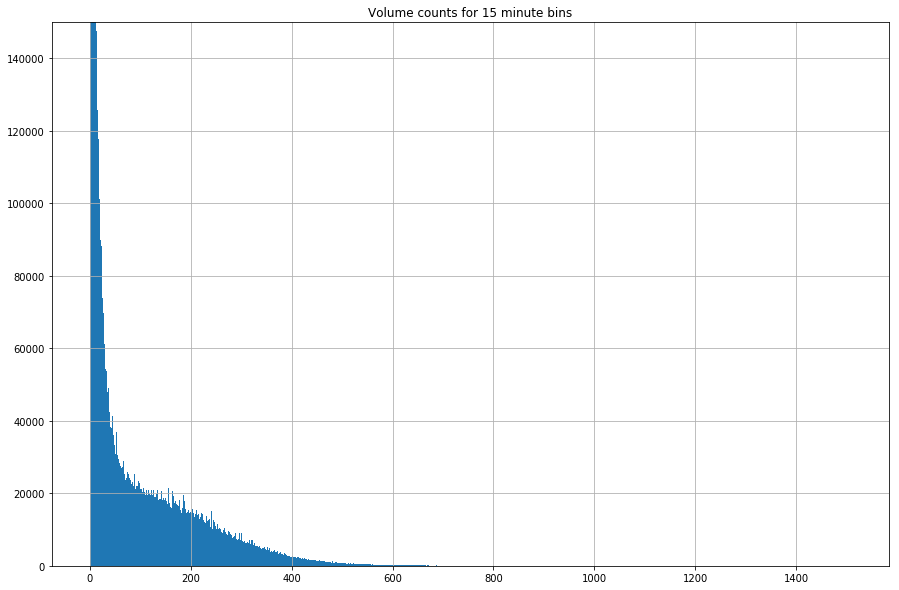

In [3]:
bin_val = np.arange(min(volumes['volume_15min']), max(volumes['volume_15min']), 1)

volumes.hist(bins=bin_val, figsize=(15,10))
plt.title('Volume counts for 15 minute bins')
plt.rc('font', size=10)          
plt.rc('axes', titlesize=15)
plt.ylim(0, 150000)

In [4]:
max(volumes['volume_15min'])

1510.0

The maximum volume is extremely high. I am going to look into this record and other records with very high volumes.

In [5]:
sql_high_volumes = '''
SELECT * 
FROM open_data.volumes_atr_shortterm
WHERE volume_15min = 9472;
'''
pandasql.read_sql(sql_high_volumes, con)

,centreline_id,direction,location,class_type,datetime_bin,volume_15min


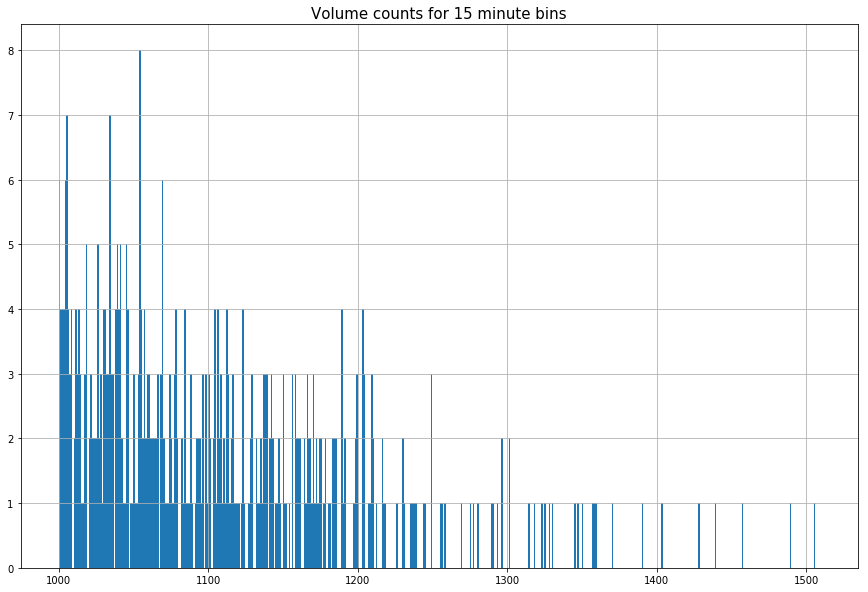

In [6]:
bin_val = np.arange(1000, max(volumes['volume_15min']), 1)

volumes.hist(bins=bin_val, figsize=(15,10))
plt.title('Volume counts for 15 minute bins')
plt.rc('font', size=10)          
plt.rc('axes', titlesize=15)

The TMC datasets had a maximum 15 min volume of under 2000. Some of the values in this dataset look very high for a 15 minute period.

In [7]:
sql_high_volumes = '''
SELECT DISTINCT centreline_id, location, COUNT(*), AVG(volume_15min) avg_volume
FROM open_data.volumes_atr_shortterm
WHERE volume_15min > 2000
GROUP BY centreline_id, location;
'''
pandasql.read_sql(sql_high_volumes, con)

,centreline_id,location,count,avg_volume


A lot of these really high volumes seem to be on taken on highways. Highways have higher speeds and so their volumes of traffic may be a lot larger than on normal city roads. However, some of these appear to be normal roadways, so some of these may be extreme values. 

I created a view with all of the outliers for ATR short term dataset called `open_data.atr_shortterm_outliers`. The code that created the view was:

```sql 
DROP MATERIALIZED VIEW IF EXISTS open_data.atr_shortterm_outliers;
CREATE MATERIALIZED VIEW open_data.atr_shortterm_outliers AS (
SELECT o.centreline_id, o.direction, o.location, o.class_type, o.datetime_bin, o.volume_15min 
FROM

(
SELECT l.centreline_id, l.location, l.direction, calc.lower, calc.upper
FROM 
(SELECT DISTINCT ON (location, centreline_id, direction) centreline_id, location, direction
FROM open_data.volumes_atr_shortterm) l LEFT JOIN
(SELECT centreline_id, location, direction, 
(percentile_cont(0.25) within group (order by volume_15min asc) - (percentile_cont(0.75) within group (order by volume_15min asc) - percentile_cont(0.25) within group (order by volume_15min asc))*1.5)  AS lower, 
(percentile_cont(0.75) within group (order by volume_15min asc) + (percentile_cont(0.75) within group (order by volume_15min asc) - percentile_cont(0.25) within group (order by volume_15min asc))*1.5) upper
FROM 
open_data.volumes_atr_shortterm
GROUP BY location, centreline_id, direction
) AS calc ON calc.location = l.location AND calc.direction = l.direction ) AS lu

JOIN 

open_data.volumes_atr_shortterm o ON  o.location = lu.location AND o.direction = lu.direction

WHERE (o.volume_15min > upper OR o.volume_15min < lower) AND upper <> lower )
WITH DATA;
```

In [8]:
sql_outliers = '''
SELECT * 
FROM open_data.atr_shortterm_outliers
'''

outliers = pandasql.read_sql(sql_outliers, con)

In [9]:
sql_volumes = '''
SELECT * FROM open_data.volumes_atr_shortterm
'''

volumes = pandasql.read_sql(sql_volumes, con)

In [10]:
# get percentage of total records that are outliers 
(len(outliers.index) / len(volumes.index))*100 

1.2055355373577805

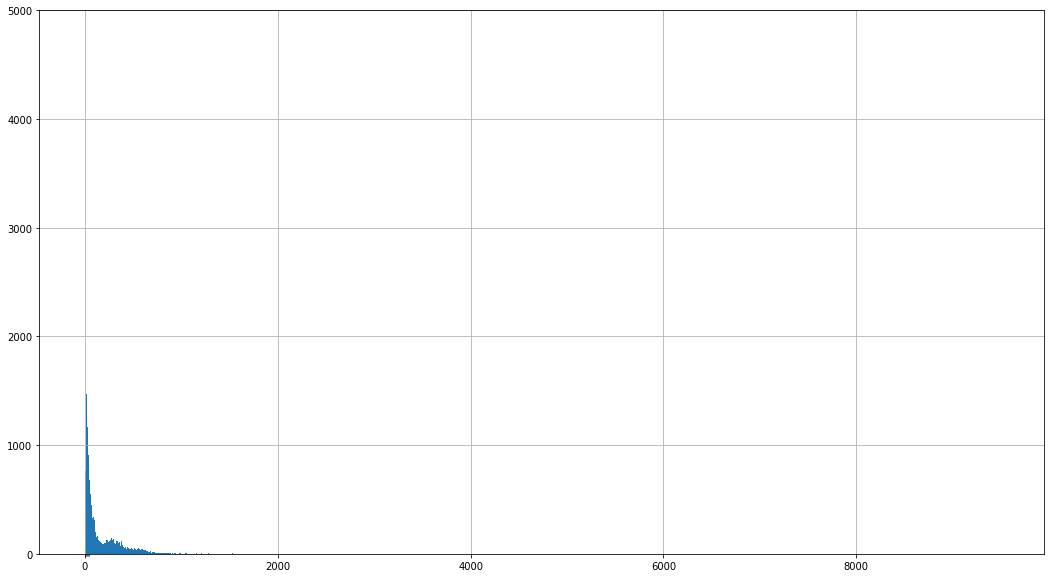

In [11]:
outliers['volume_15min'].hist(bins = np.arange(min(outliers['volume_15min']), max(outliers['volume_15min']) , 1), 
                              figsize = (18, 10))
ax = plt.gca()
minor_ticks = np.arange(0, 50, 10)
major_ticks = np.arange(0, 50, 100)

#ax.set_xticks(major_ticks, labels=[major_ticks])
ax.set_xticks(minor_ticks, minor=True)

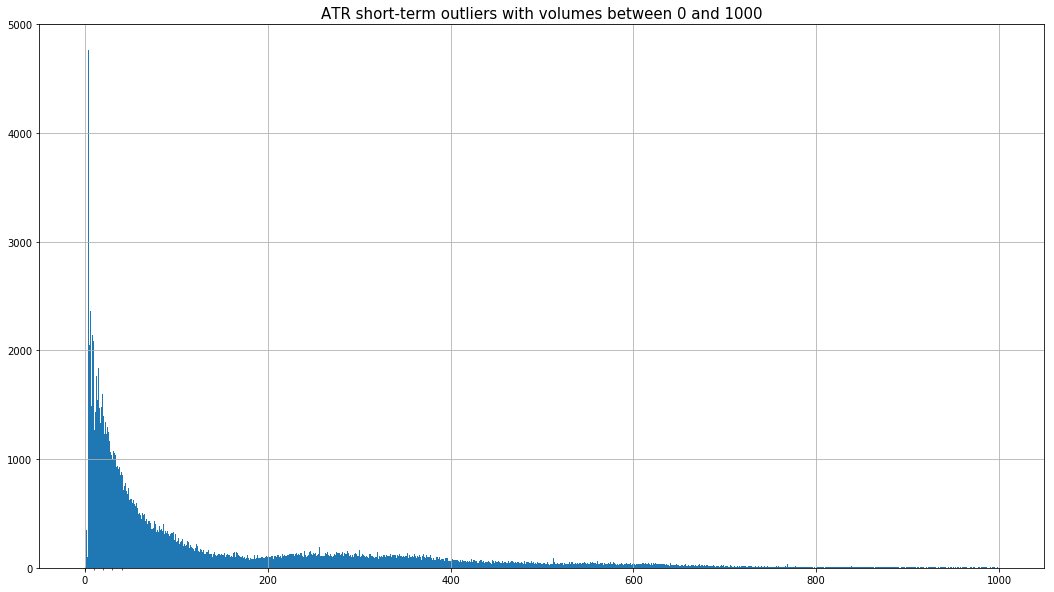

In [12]:
outliers['volume_15min'].hist(bins = np.arange(0, 1000, 1), figsize = (18, 10))
ax = plt.gca()
minor_ticks = np.arange(0, 50, 10)
major_ticks = np.arange(0, 50, 100)

plt.title("ATR short-term outliers with volumes between 0 and 1000")
#ax.set_xticks(major_ticks, labels=[major_ticks])
ax.set_xticks(minor_ticks, minor=True)

There ara a lot of volume values that are low and are not really "exteme" values for volumes. I investigated some of the intersections where the volumes under 5 occured, and they were not major streets, so the values are logical. 

Try modifying the IQR process by using different values for k, I used 2, 2.5, and 3 as k values. Below is the code and analysis of the outliers when the k-value was equal to 3.

```sql 
DROP MATERIALIZED VIEW IF EXISTS open_data.atr_shortterm_outliers_k3;
CREATE MATERIALIZED VIEW open_data.atr_shortterm_outliers_k3 AS (
SELECT o.centreline_id, o.direction, o.location, o.class_type, o.datetime_bin, o.volume_15min 
FROM

(
SELECT l.centreline_id, l.location,  l.direction, calc.lower, calc.upper
FROM 
(SELECT DISTINCT ON (centreline_id, location, direction) centreline_id, location, direction
FROM open_data.volumes_atr_shortterm) l LEFT JOIN
(SELECT centreline_id, location, direction, 
(percentile_cont(0.25) within group (order by volume_15min asc) - (percentile_cont(0.75) within group (order by volume_15min asc) - percentile_cont(0.25) within group (order by volume_15min asc))*3)  AS lower, 
(percentile_cont(0.75) within group (order by volume_15min asc) + (percentile_cont(0.75) within group (order by volume_15min asc) - percentile_cont(0.25) within group (order by volume_15min asc))*3) upper
FROM 
open_data.volumes_atr_shortterm
GROUP BY centreline_id, location, direction
) AS calc ON calc.location = l.location AND calc.direction = l.direction ) AS lu

JOIN 

open_data.volumes_atr_shortterm o ON  o.location = lu.location AND o.direction = lu.direction

WHERE (o.volume_15min > upper OR o.volume_15min < lower) AND upper <> lower )
WITH DATA;
```

In [13]:
sql_outliers = '''
SELECT * 
FROM open_data.atr_shortterm_outliers_k3
'''

outliers_k2 = pandasql.read_sql(sql_outliers, con)

In [14]:
# get percentage of total records that are outliers 
(len(outliers_k2.index) / len(volumes.index))*100 

0.22807919619711312

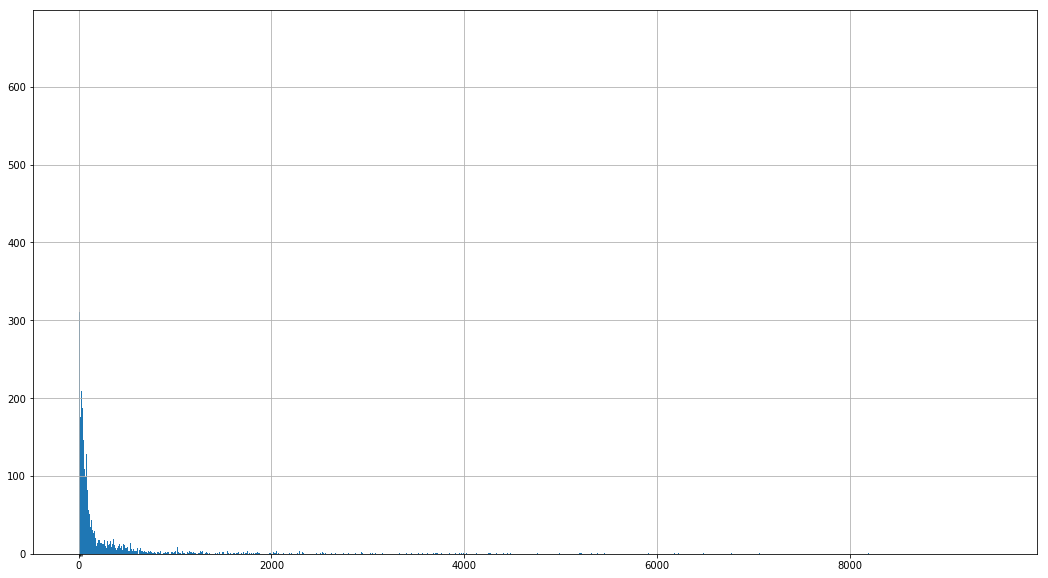

In [15]:
outliers_k2['volume_15min'].hist(bins = np.arange(min(outliers_k2['volume_15min']), max(outliers_k2['volume_15min']) , 1), 
                                 figsize = (18, 10))
ax = plt.gca()
minor_ticks = np.arange(0, 50, 10)
major_ticks = np.arange(0, 50, 100)

ax.set_xticks(minor_ticks, minor=True)

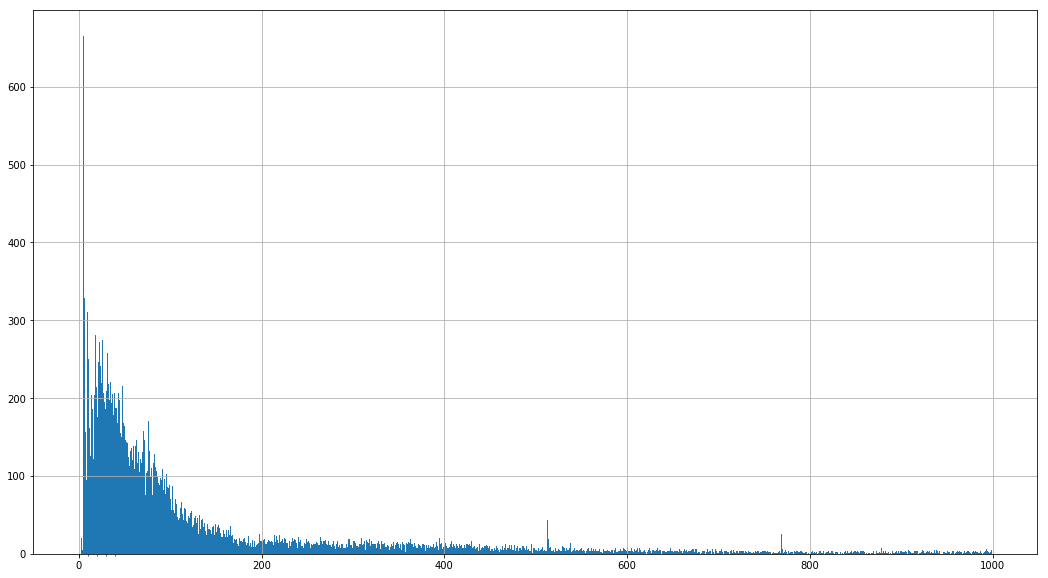

In [16]:
outliers_k2['volume_15min'].hist(bins = np.arange(0, 1000 , 1), figsize = (18, 10))
ax = plt.gca()
minor_ticks = np.arange(0, 50, 10)
major_ticks = np.arange(0, 50, 100)

ax.set_xticks(minor_ticks, minor=True)

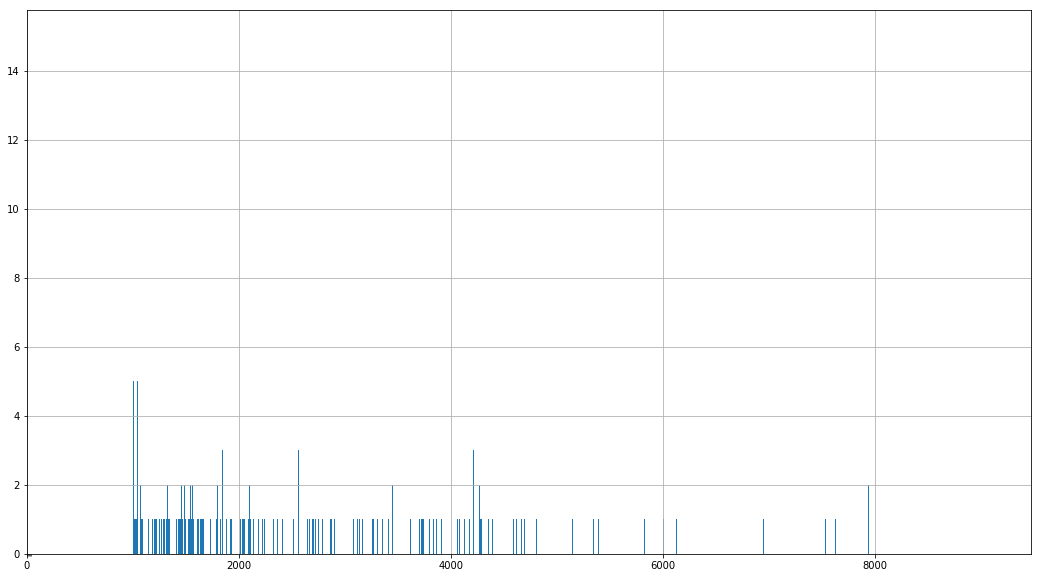

In [17]:
outliers_k2['volume_15min'].hist(bins = np.arange(1000,  max(outliers_k2['volume_15min']) , 1), figsize = (18, 10))
ax = plt.gca()
minor_ticks = np.arange(0, 50, 10)
major_ticks = np.arange(0, 50, 100)
plt.xlim(1000,  max(outliers_k2['volume_15min']))
ax.set_xticks(minor_ticks, minor=True)

In [18]:
sql_over200_locations = '''
SELECT location, COUNT(*) FROM open_data.atr_shortterm_outliers_k3 WHERE volume_15min > 2000 GROUP BY location
'''
pandasql.read_sql(sql_over200_locations, con)

,location,count
0,F G GARDINER EXPY (COLL) E/B W OF ISLINGTON AVE,17
1,F G GARDINER EXPY W/B TO HIGHWAY 427 N/B & BRO...,63
2,F G GARDINER EXPY (CORE) E/B W OF ISLINGTON AVE,122
3,F G GARDINER EXPY E/B W OF HUMBER RIVER,69
4,BRIMLEY RD N/B S OF CHARTLAND BLVD S,7
5,F G GARDINER EXPY (CORE) W/B W OF ISLINGTON AVE,54
6,MCCOWAN RD S/B N OF HIGHWAY 401 N TCS,2
7,CHERRY ST S/B N OF COMMISSIONERS ST,70
8,HIGHWAY 2A W/B E OF HIGHWAY 401,1
9,BLACK CREEK DR N/B N OF JANE ST,2


Look into outliers with very low volumes by seeing if these low values are true outliers or if they are part of the distribution.

In [2]:
sql = '''
-- check out upper and lower values
SELECT DISTINCT l.location, l.direction, calc.lower, calc.upper
FROM 


(SELECT DISTINCT ON (location, direction) centreline_id, location, direction
FROM open_data.volumes_atr_shortterm) l 


LEFT JOIN


(SELECT location, direction, 
(percentile_cont(0.25) 
within group (order by volume_15min asc) - (percentile_cont(0.75) 
within group (order by volume_15min asc) - percentile_cont(0.25) within group (order by volume_15min asc))*3)  AS lower, 
(percentile_cont(0.75) 
within group (order by volume_15min asc) + (percentile_cont(0.75) 
within group (order by volume_15min asc) - percentile_cont(0.25) within group (order by volume_15min asc))*3) upper
FROM 
open_data.volumes_atr_shortterm
GROUP BY location, direction) AS calc 


ON calc.location = l.location AND calc.direction = l.direction



WHERE l.centreline_id = 7439 AND l.direction = 'Eastbound'

'''

pandasql.read_sql(sql, con)

,location,direction,lower,upper
0,SPEERS AVE E/B W OF JANE ST,Eastbound,-6.0,8.0


In [5]:
sql_volumes7429 = '''
SELECT * FROM open_data.volumes_atr_shortterm
WHERE centreline_id = 7439
'''

volumes7439 = pandasql.read_sql(sql_volumes7429, con)
# add hour column
def get_hour(row):
    return row['datetime_bin'].hour

volumes7439['hour'] = volumes7439.apply(lambda row:  get_hour (row), axis=1)  


sql_outliers7429 = '''
SELECT * FROM open_data.atr_shortterm_outliers
WHERE centreline_id = 7439
'''

outliers_7439 = pandasql.read_sql(sql_outliers7429, con)

outliers_7439['hour'] = outliers_7439.apply(lambda row:  get_hour (row), axis=1)  


sql_outliers = '''
SELECT * 
FROM open_data.atr_shortterm_outliers_k3
WHERE centreline_id = 7439
'''
k7439 = pandasql.read_sql(sql_outliers, con)

k7439['hour'] = k7439.apply(lambda row:  get_hour (row), axis=1)  


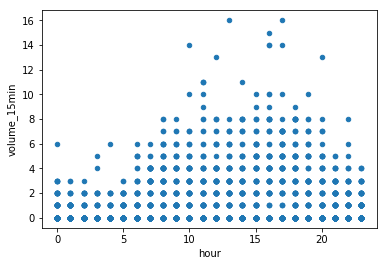

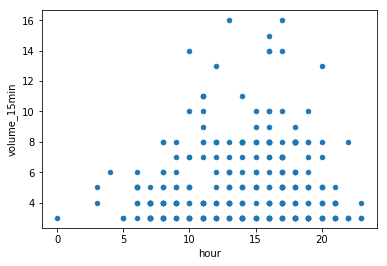

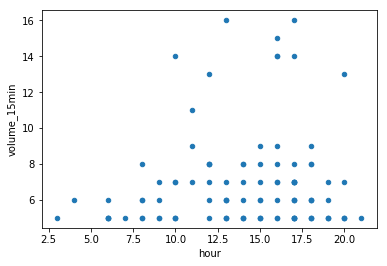

In [6]:
volumes7439.plot.scatter(x='hour', y='volume_15min')
outliers_7439.plot.scatter('hour', 'volume_15min')
k7439.plot.scatter('hour', 'volume_15min')

Some/most of the points in both of the last two plots were not true outliers, as they occur within the general distribution of the first scatter plot. On the plus side, the true outliers were included in both plots. 

Try to edit the outlier criteria by looking at outliers by location, direction (like before) and additionally class type (i.e. Pedestrians, Cyclists, etc.). See if this change effects the validity of the outliers being defined.

Code: 
```sql 

DROP MATERIALIZED VIEW IF EXISTS open_data.atr_shortterm_outliers_class;
CREATE MATERIALIZED VIEW open_data.atr_shortterm_outliers_class AS (
SELECT o.centreline_id, o.direction, o.location, o.class_type, o.datetime_bin, o.volume_15min 
FROM

(
SELECT l.centreline_id, l.location, l.direction, calc.lower, calc.upper, l.class_type
FROM 
(SELECT DISTINCT ON (location, centreline_id, direction, class_type) centreline_id, location, direction, class_type
FROM open_data.volumes_atr_shortterm) l LEFT JOIN
(SELECT centreline_id, location, direction, class_type,
(percentile_cont(0.25) within group (order by volume_15min asc) - (percentile_cont(0.95) within group (order by volume_15min asc) - percentile_cont(0.05) within group (order by volume_15min asc))*3)  AS lower, 
(percentile_cont(0.75) within group (order by volume_15min asc) + (percentile_cont(0.95) within group (order by volume_15min asc) - percentile_cont(0.05) within group (order by volume_15min asc))*3) upper
FROM 
open_data.volumes_atr_shortterm
GROUP BY location, centreline_id, direction, class_type
) AS calc ON calc.location = l.location AND calc.direction = l.direction AND calc.class_type = l.class_type) AS lu

JOIN 

open_data.volumes_atr_shortterm o ON  o.location = lu.location AND o.direction = lu.direction AND o.class_type = lu.class_type

WHERE (o.volume_15min > upper OR o.volume_15min < lower) AND upper <> lower )
WITH DATA;


```

In [14]:
sql_outliers = '''
SELECT * 
FROM open_data.atr_shortterm_outliers_class
'''

outliers_class = pandasql.read_sql(sql_outliers, con)

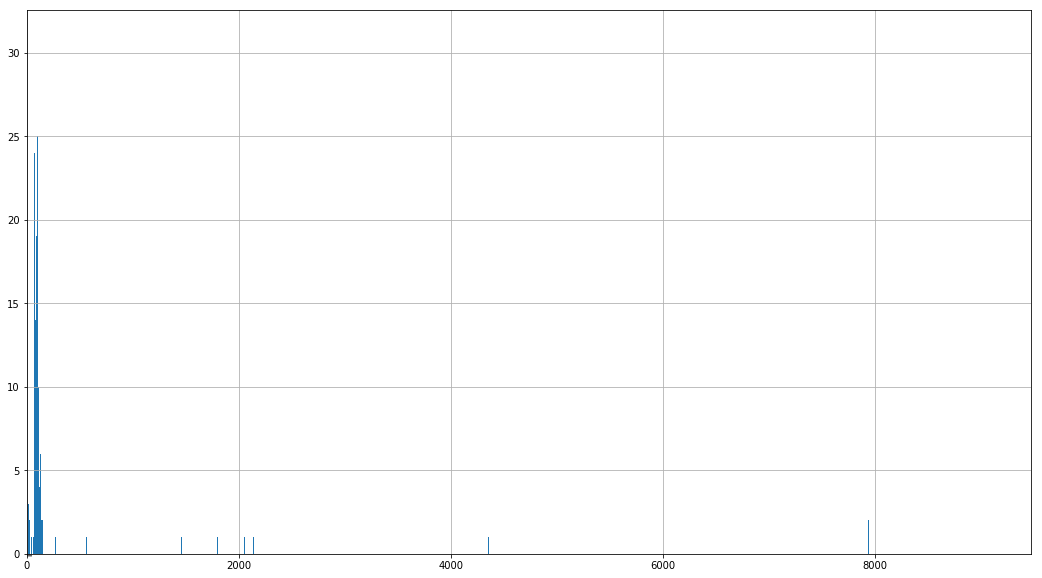

In [15]:
outliers_class['volume_15min'].hist(bins = np.arange(min(outliers_class['volume_15min']), 
                                                     max(outliers_class['volume_15min']) , 1), figsize = (18, 10))
ax = plt.gca()
minor_ticks = np.arange(0, 50, 10)
major_ticks = np.arange(0, 50, 100)
plt.xlim(min(outliers_class['volume_15min']), max(outliers_class['volume_15min']))

ax.set_xticks(minor_ticks, minor=True)

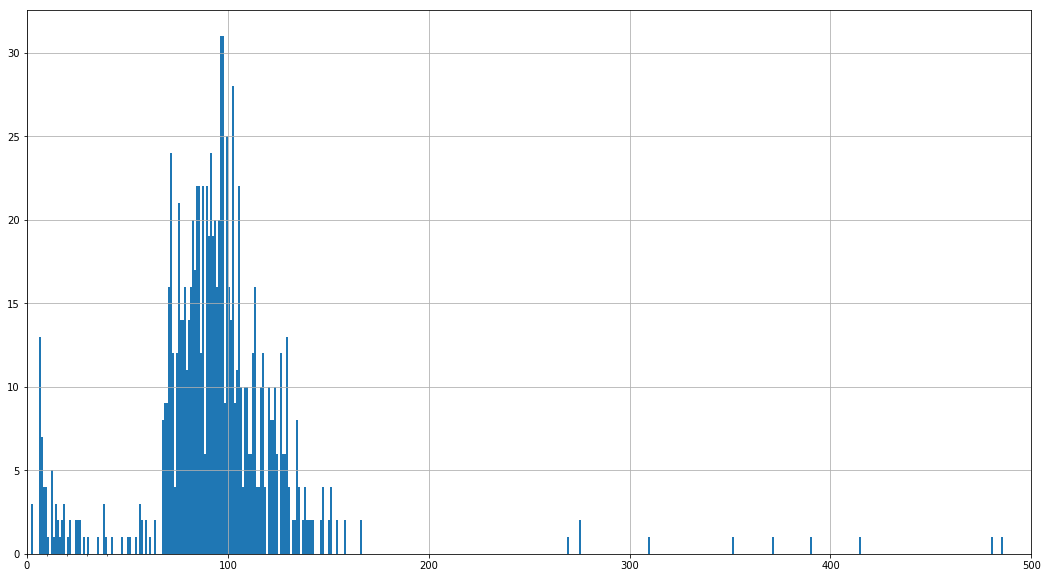

In [16]:
outliers_class['volume_15min'].hist(bins = np.arange(min(outliers_class['volume_15min']),
                                                     max(outliers_class['volume_15min']) , 1), figsize = (18, 10))
ax = plt.gca()
minor_ticks = np.arange(0, 50, 10)
major_ticks = np.arange(0, 50, 100)
plt.xlim(0,500)

ax.set_xticks(minor_ticks, minor=True)

As you can see from the above histograms and scatter plot, the same phenomenon where low values that are in and around 0 are being classified as outliers. These values may be outliers, but they are definitely not extreme values. 

The next approach to remove extreme values that I tried was completely different than the first few. When looking over the dataset, it was noticed that there are a lot of volumes of 0 that should not be 0, followed by an extremely large volume. I started by creating an exceptions view that contained all of the records that occur on days and at locations where there exists a value of 0 and a value above 20 within an hour of each other. After that, I realized that there were still some extreme values in the dataset. I then refined the query that created the exceptions view to include records that occur on dates and at locations where there was a volume of under 450 and a volume of over 1000 wihtin an hour of each other. Additionally, the exceptions view also includes date-location combinations that have less than or equal to 3 records and have a maximum value that is extremely high (over 1000) or a minimum volume of under 5, and date-location combinations where the maximum volume is 0 or the average volume is 0. 

The code to create the view: 
```sql 
DROP MATERIALIZED VIEW IF EXISTS open_data.volumes_atr_shortterm_exceptions;
CREATE MATERIALIZED VIEW  open_data.volumes_atr_shortterm_exceptions AS 
(
-- get day/locations where there exists a value of 0 and a value above 20 within an hour of each other. 
-- Also get days that have a volume of under 450 and a volume of over 1000 wihtin an hour of each other
SELECT o1.datetime_bin::date, o1.location 
FROM open_data.volumes_atr_shortterm o1 JOIN open_data.volumes_atr_shortterm o2 ON o1.location = o2.location  
WHERE (CASE WHEN (o1.datetime_bin - o2.datetime_bin) < interval '0' THEN (-(o1.datetime_bin - o2.datetime_bin)) ELSE (o1.datetime_bin - o2.datetime_bin) END) <= interval '1 hour' 
AND ((o1.volume_15min > 20 AND o2.volume_15min = 0) OR (o1.volume_15min < 450 AND o2.volume_15min > 1000) ) 

UNION 

(SELECT o2.datetime_bin::date, o2.location FROM open_data.volumes_atr_shortterm o1 JOIN open_data.volumes_atr_shortterm o2 ON o1.location = o2.location 
WHERE (CASE WHEN (o1.datetime_bin - o2.datetime_bin) < interval '0' THEN (-(o1.datetime_bin - o2.datetime_bin)) ELSE (o1.datetime_bin - o2.datetime_bin) END) <= interval '1 hour' AND 
((o1.volume_15min > 20 AND o2.volume_15min = 0) OR (o1.volume_15min < 450 AND o2.volume_15min > 1000))  )

 
UNION 

-- get days that only have less than 3 records for a location+date and a max value that is strangley high or a mininum value for that location+date that is extremely low
(
SELECT datetime_bin::DATE, location
FROM open_data.volumes_atr_shortterm v
GROUP BY datetime_bin::DATE, location
-- CHANGE MAX TO OVER 1000 ??? WOULD HELP IN BURNHAMTHORPE AND RENFORTH THING and etobicoke creek/bloor 
HAVING (COUNT(*) <= 3 AND (MAX(volume_15min) > 1000 OR MIN(volume_15min) <= 5)) OR AVG(volume_15min) = 0
)

);
```


## QA/QC checks 

In order to make sure all of the extreme values were identified and that the values in the exception table are extreme (or occur on the same day as extreme values), I did extensive QA/QC. 

In [9]:
sql = '''
-- max that is not in exceptions table is 1359
SELECT MAX(volume_15min) 
FROM open_data.volumes_atr_shortterm 
WHERE location NOT IN 
(SELECT location FROM (SELECT DISTINCT location, datetime_bin::DATE FROM open_data.volumes_atr_shortterm_exceptions) x) 
AND datetime_bin::DATE NOT IN 
(SELECT datetime_bin FROM (SELECT DISTINCT location, datetime_bin::DATE FROM open_data.volumes_atr_shortterm_exceptions) x) 
'''

pandasql.read_sql(sql, con)

,max
0,1359.0


In [10]:
# look at values that are NOT in exceptions table but are over 1000
# I checked quite a few (a bit under 10) of the locations here by running queries such as:
# SELECT * FROM open_data.volumes_atr_shortterm WHERE location = 'EGLINTON AVE W/B W OF MARTIN GROVE RD'
# I found that the volume values gradually increase, reach above 1000, and then gradually decrease 
# so I have no reason to believe that these values over 1000 are extreme values
sql = '''
SELECT * 
FROM open_data.volumes_atr_shortterm 
WHERE location NOT IN 
(SELECT location FROM (SELECT DISTINCT location, datetime_bin::DATE FROM open_data.volumes_atr_shortterm_exceptions) x) 
AND datetime_bin::DATE NOT IN 
(SELECT datetime_bin FROM (SELECT DISTINCT location, datetime_bin::DATE FROM open_data.volumes_atr_shortterm_exceptions) x) 
AND volume_15min > 1000
'''

pandasql.read_sql(sql, con)

,centreline_id,direction,location,class_type,datetime_bin,volume_15min
0,107638.0,Northbound,KENNEDY RD N/B TO HIGHWAY 401 W/B,Vehicles,1994-03-17 12:00:00,1059.0
1,12377332.0,Westbound,EGLINTON AVE W/B W OF MARTIN GROVE RD,Vehicles,1999-04-21 07:30:00,1008.0
2,12377332.0,Westbound,EGLINTON AVE W/B W OF MARTIN GROVE RD,Vehicles,1999-04-21 07:45:00,1058.0
3,12377332.0,Westbound,EGLINTON AVE W/B W OF MARTIN GROVE RD,Vehicles,1999-04-21 08:00:00,1178.0
4,12377332.0,Westbound,EGLINTON AVE W/B W OF MARTIN GROVE RD,Vehicles,1999-04-21 08:15:00,1258.0
5,12377332.0,Westbound,EGLINTON AVE W/B W OF MARTIN GROVE RD,Vehicles,1999-04-21 08:30:00,1216.0
6,12377332.0,Westbound,EGLINTON AVE W/B W OF MARTIN GROVE RD,Vehicles,1999-04-21 08:45:00,1118.0
7,12377332.0,Westbound,EGLINTON AVE W/B W OF MARTIN GROVE RD,Vehicles,1999-04-21 09:00:00,1034.0
8,7273868.0,Southbound,YONGE ST S/B S MERTON ST,Vehicles,2002-08-02 08:00:00,1054.0
9,7273868.0,Southbound,YONGE ST S/B S MERTON ST,Vehicles,2002-08-02 08:15:00,1296.0


In [11]:
# look at other really high volumes that are not over 1000 and NOT in the exceptions table 
# I looked at a lot (around 5) of these date-location combinations randomly 
# and the progression to a large value (800-1000) was normal (i.e. gradually increase to large value(s) then gradually decrease)
sql = '''
SELECT * 
FROM open_data.volumes_atr_shortterm 
WHERE location 
NOT IN (SELECT DISTINCT location FROM open_data.volumes_atr_shortterm_exceptions) 
AND volume_15min > 800 AND volume_15min < 1000 
ORDER BY location, datetime_bin
LIMIT 1000
'''
pandasql.read_sql(sql, con)

,centreline_id,direction,location,class_type,datetime_bin,volume_15min
0,NaN,Southbound,427 S/B TO THE QUEENSWAY W/B,Vehicles,1996-06-27 17:15:00,892.0
1,12373944.0,Northbound,BAYVIEW AVE EXT N/B TO BAYVIEW BLOOR RAMP E/B,Vehicles,1993-04-28 12:45:00,828.0
2,12373944.0,Northbound,BAYVIEW AVE EXT N/B TO BAYVIEW BLOOR RAMP E/B,Vehicles,1993-04-28 13:00:00,811.0
3,12373944.0,Northbound,BAYVIEW AVE EXT N/B TO BAYVIEW BLOOR RAMP E/B,Vehicles,1993-04-28 13:15:00,867.0
4,437495.0,Northbound,BAYVIEW AVE N/B S OF FINCH AVE,Vehicles,1996-05-30 16:45:00,877.0
5,437495.0,Northbound,BAYVIEW AVE N/B S OF FINCH AVE,Vehicles,1996-05-30 17:30:00,845.0
6,437495.0,Northbound,BAYVIEW AVE N/B S OF FINCH AVE,Vehicles,1996-05-30 17:45:00,801.0
7,437495.0,Northbound,BAYVIEW AVE N/B S OF FINCH AVE,Vehicles,1996-05-30 18:15:00,873.0
8,437495.0,Northbound,BAYVIEW AVE N/B S OF FINCH AVE,Vehicles,1996-05-30 18:30:00,914.0
9,437495.0,Northbound,BAYVIEW AVE N/B S OF FINCH AVE,Vehicles,1996-05-30 18:45:00,801.0


In [ ]:
# Find the number of records over the value of 1000 that are not in the exceptions table
# Most of them are in the exceptions table
# there are some values over 1000 that are not in the exceptions table
# this would make sense because some volumes are taken on highways or large/busy roads
# also road/highway closures could potentially affect traffic volumes on certain streets/highways
sql = '''
SELECT 
(SELECT COUNT(*) FROM open_data.volumes_atr_shortterm_exceptions_rough WHERE volume_15min > 1000) cnt_exceptions,
(SELECT COUNT(*) FROM open_data.volumes_atr_shortterm WHERE volume_15min > 1000) cnt, 
(SELECT COUNT(*) FROM open_data.volumes_atr_shortterm WHERE volume_15min > 1000) - 
(SELECT COUNT(*) FROM open_data.volumes_atr_shortterm_exceptions_rough WHERE volume_15min > 1000) cnt_diff
'''
pandasql.read_sql(sql, con)

In [ ]:
# All the volumes over 2000 are classified as exceptions
# These values are definitely extreme values so this is good
sql = '''
SELECT 
(SELECT COUNT(*) FROM open_data.volumes_atr_shortterm_exceptions WHERE volume_15min > 2000) cnt_exceptions,
(SELECT COUNT(*) FROM open_data.volumes_atr_shortterm WHERE volume_15min > 2000) cnt, 
(SELECT COUNT(*) FROM open_data.volumes_atr_shortterm WHERE volume_15min > 2000) - 
(SELECT COUNT(*) FROM open_data.volumes_atr_shortterm_exceptions WHERE volume_15min > 2000) cnt_diff
'''
pandasql.read_sql(sql, con)

In [19]:
# this query looks at the locations where there are very low average volumes 
# There are some locations with an average volume of 0 
# I made sure the records with that location and an average volume of zero were in the exceptions table
# I looked at some all records for some locations with very low averages 
# they all seemed to make enough sense, even the locations with an average volume under 1
# I kept these values out of the exceptions table because I did not have enough evidence to prove that they were extreme values
# most of these locations with small averages were streets in residential areas

sql = '''
SELECT DISTINCT location, AVG(volume_15min), MAX(volume_15min), COUNT(*) 
FROM open_data.volumes_atr_shortterm o 
GROUP BY location 
HAVING AVG(volume_15min) < 3 
ORDER BY AVG(volume_15min)
'''
pandasql.read_sql(sql, con)

,location,avg,max,count
0,ORCHARD PARK BLVD S/B N OF QUEEN ST E,0.020833,1.0,96
1,PHARMACY AVE S/B S OF HUNTINGWOOD DR,0.020833,1.0,96
2,LAUDER AVE N/B N OF REGAL RD,0.024306,1.0,288
3,FLORENCE CRES N/B S OF PRITCHARD AVE,0.026042,1.0,192
4,LYNNGROVE AVE E/B W OF BELVALE AVE,0.026042,1.0,192
5,ELDER ST N/B S OF KENNARD AVE,0.031250,2.0,96
6,LN N DUNDAS W CLENDENAN W/B E OF ST JOHNS PL,0.031250,1.0,96
7,MACPHAIL AVE E/B W OF PAPE AVE,0.031250,1.0,288
8,KANE AVE N/B S OF CAMERON AVE,0.036458,2.0,576
9,JACKMAN AVE N/B S OF BROWNING AVE,0.041667,1.0,288


## Creating the final view

Use the exceptions view create the final `open_data.volumes_atr_shortterm` view. 
```sql 
CREATE OR REPLACE VIEW open_data.volumes_atr_shortterm AS 
 SELECT flow_atr.centreline_id,
    flow_atr.direction,
    flow_atr.location,
    flow_atr.class_type,
    flow_atr.datetime_bin,
    flow_atr.volume_15min
   FROM open_data.flow_atr
  WHERE flow_atr.station_type = 'Short Term'::text AND flow_atr.volume_15min >= 0::numeric 
  AND NOT (EXISTS ( SELECT * 
           FROM open_data.volumes_atr_shortterm_exceptions exceptions
          WHERE exceptions.datetime_bin::date = flow_atr.datetime_bin::date AND exceptions.location::text = flow_atr.location::text));
```

In [ ]:
con.close()